In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
%matplotlib inline
%load_ext watermark
%load_ext autoreload 
%autoreload 2

from scipy.stats import norm, bernoulli

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,matplotlib,scipy

Ethen 2017-01-07 10:32:47 

CPython 3.5.2
IPython 4.2.0

numpy 1.11.3
pandas 0.18.1
matplotlib 1.5.1
scipy 0.18.1


In [3]:
# define size of two regions (changepoint occurring at the middle)
size1 = 2500
size2 = 2500

scale = 50 # standard deviation of distribution function
loc1 = 1000 # mean of normal for first part
loc2 = 1020 # mean of normal for second part
d1 = norm.rvs(loc = loc1, size = size1, scale = scale)
d2 = norm.rvs(loc = loc2, size = size2, scale = scale)
data = np.r_[d1, d2]
data

array([  955.11482345,   964.14265604,   952.99736837, ...,  1109.61915633,
        1052.35240098,  1076.64329301])

In [5]:
def compute_normal_loglike(data, cutoff):
    """
    compute log-likelihood ratio, R,
    across all possible time tau
    
    cutoff: 
        time index at the beginning and end that will not be evaluated
    """
    n = data.shape[0]
    loss_h0 = np.sum((data - np.mean(data)) ** 2)
    print(loss_h0)
    # this part can be easily parallelized
    loss_before_change = np.asarray([ np.sum( (data[:i] - np.mean(data[:i])) ** 2 ) 
                                      for i in range(cutoff, n - cutoff) ])
    loss_after_change = np.asarray([ np.sum( (data[i:] - np.mean(data[i:])) ** 2 ) 
                                     for i in range(cutoff, n - cutoff) ])
    loss_h1 = loss_before_change + loss_after_change
    R = -1 / (2 * np.var(data)) * (loss_h1 - loss_h0)
    print(R)
    return R

In [7]:
compute_normal_loglike(data, cutoff = 10)

12771524.2763
[ 0.35185679  0.46461767  0.60819908 ...,  1.13529216  1.31881872
  1.71924538]


array([ 0.35185679,  0.46461767,  0.60819908, ...,  1.13529216,
        1.31881872,  1.71924538])

In [8]:
def plot_changepoint(data, cutoff, R):
    """
    if there is no change point,
    then it will be a normal time series plot
    """
    n = data.shape[0]
    plot_setting = {'color': 'r', 'lw': 2}
    plt.plot(range(1, n + 1), data)
    plt.xlabel('Time')
    
    # there is a changepoint if the largest log-likelihood
    # ratio, R, is larger than a user-specified threshold, 
    # here it is set to 3/2 of the upper quantile of all the data
    # http://flowingdata.com/2008/02/15/how-to-read-and-use-a-box-and-whisker-plot/
    upper_quantile = np.percentile(R, 75)
    threshold = 3 / 2 * upper_quantile
    G = np.amax(R)
    if G > threshold:
        print('G:', G)
        print('threshold:', threshold)
        # round the mean for nicer printing
        changepoint = np.argmax(R) + cutoff
        mean_before = np.round( np.mean(data[:changepoint]), 2 )
        mean_after = np.round( np.mean(data[changepoint + 1:]), 2 )

        # add the horizontal line for previous and new mean,
        # and a vertical line indicating the changepoint
        plt.plot([0, changepoint], [mean_before, mean_before], **plot_setting)
        plt.plot([changepoint + 1, n], [mean_after, mean_after], **plot_setting)
        plt.axvline(changepoint + 0.5, linestyle = '--', **plot_setting)
        title = """
                changepoint detected at time {},\n 
                previous mean {}, new mean {}
                """.format(changepoint, mean_before, mean_after)
    else:
        m = np.round(np.mean(data), 2)
        title = 'mean {}'.format(m)
        plt.plot([0, n], [m, m], **plot_setting)
    
    plt.title(title)
    plt.tight_layout()

12771524.2763
[ 0.82638179  0.69644515  0.78931296 ...,  0.97839074  1.29960936
  1.47123294]
G: 110.818359377
threshold: 94.2456254375


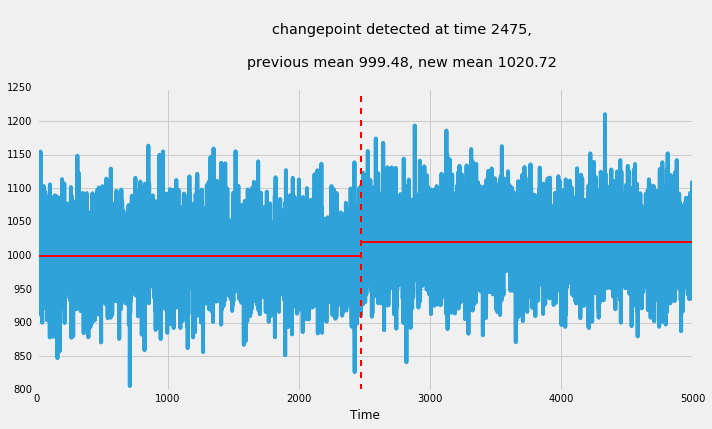

In [9]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['font.size'] = 10

cutoff = 30
R = compute_normal_loglike(data, cutoff)
plot_changepoint(data, cutoff, R)

In [9]:
p1 = 0.9
p2 = 0.85
d1 = bernoulli.rvs(p1,size=size1)
d2 = bernoulli.rvs(p2,size=size2)
data = np.r_[d1, d2]
data

array([1, 1, 1, ..., 0, 1, 1])